#  SETUP


In [1]:
%%capture
!pip install xarray
!pip install netcdf4
!pip install collections
!pip install scikit-image
!pip install pysteps
!pip install cartopy
!pip install pysteps

In [2]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [3]:
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance


import os
import math
import copy
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import xarray as xr
import IPython.display as display
import logging
import torch.nn.functional as F
import collections
import copy


from torch import optim
from PIL import Image
from torch.utils import data
from torchvision import datasets, transforms
from functools import partial
from abc import abstractmethod
from skimage.transform import rescale


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker


from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim

from src.utils import *
from src.utils_essential import *


from src.dataloader_sr import gfdl_eval_256, era5_upscaled_1d_256, era5_0_25d_256, SR_BC_GFDL_Dataset_256

Pysteps configuration file found at: /usr/local/lib/python3.10/dist-packages/pysteps/pystepsrc



In [4]:
bs_valid = 1400

In [5]:
sr_gfdl_ds = SR_BC_GFDL_Dataset_256('data/100_gfdl_sr_imagen_e100_6_09.pth') 
sr_gfdl_dl = data.DataLoader(sr_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_gfdl = next(iter(sr_gfdl_dl)).cpu()
print("SR GFDL:",dm_sr_gfdl.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1400, 1, 256, 256])
SR GFDL: torch.Size([1400, 1, 256, 256])


In [6]:
qm_first = False

if qm_first == True:
    qm_gfdl_ds = QM_GFDL_LR_Dataset_256('data/11_01_deltaQM_debiased_gfdl_valid_custom_dl.pth' ) 
    print("Benchmarked QM + Ups:")
if qm_first == False:
    qm_gfdl_ds = SR_BC_GFDL_Dataset_256('data/QM_hr_debiased_gfdl_valid_clip_0.pth') 
    print("Benchmarked Ups + QM:")

qm_gfdl_dl = data.DataLoader(qm_gfdl_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

qm_gfdl = next(iter(qm_gfdl_dl)).cpu().unsqueeze(1)
print(qm_gfdl.shape)

dataset size torch.Size([1400, 256, 256])
Benchmarked Ups + QM:
torch.Size([1400, 1, 256, 256])


In [7]:
era5_lr_ds = era5_upscaled_1d_256(stage='valid')

era5_lr_dl = data.DataLoader(era5_lr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_lr = next(iter(era5_lr_dl))
print("LR ERA5:", era5_lr.shape)

LR ERA5: torch.Size([1400, 1, 256, 256])


In [8]:
era5_hr_ds = era5_0_25d_256(stage='valid')
era5_hr_dl = data.DataLoader(era5_hr_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

era5_hr = next(iter(era5_hr_dl))
print("HR ERA5", era5_hr.shape)

HR ERA5 torch.Size([1400, 1, 256, 256])


In [9]:
gfdl_256_ds = gfdl_eval_256(stage='valid')
gfdl_256_dl = data.DataLoader(gfdl_256_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

gfdl_256 = next(iter(gfdl_256_dl))
print("HR original GFDL", gfdl_256.shape)

HR original GFDL torch.Size([1400, 1, 256, 256])


In [10]:
dm_hr_era5_ds = SR_BC_GFDL_Dataset_256('data/100_era5_val_sr_imagen_20_09.pth')

dm_hr_era5_dl = data.DataLoader(dm_hr_era5_ds, batch_size=bs_valid, shuffle=False, drop_last=True)

dm_hr_era5 = next(iter(dm_hr_era5_dl))
print("SR ERA5 val:",dm_hr_era5.shape)

/dss/dsshome1/0D/ge74xuf2/climate_diffusion/src/dataloader_sr.py:491: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.hr_bc_gfdl = torch.load(self.path)


dataset size torch.Size([1420, 1, 256, 256])
SR ERA5 val: torch.Size([1400, 1, 256, 256])


# Evaluate SR-BC ERA5


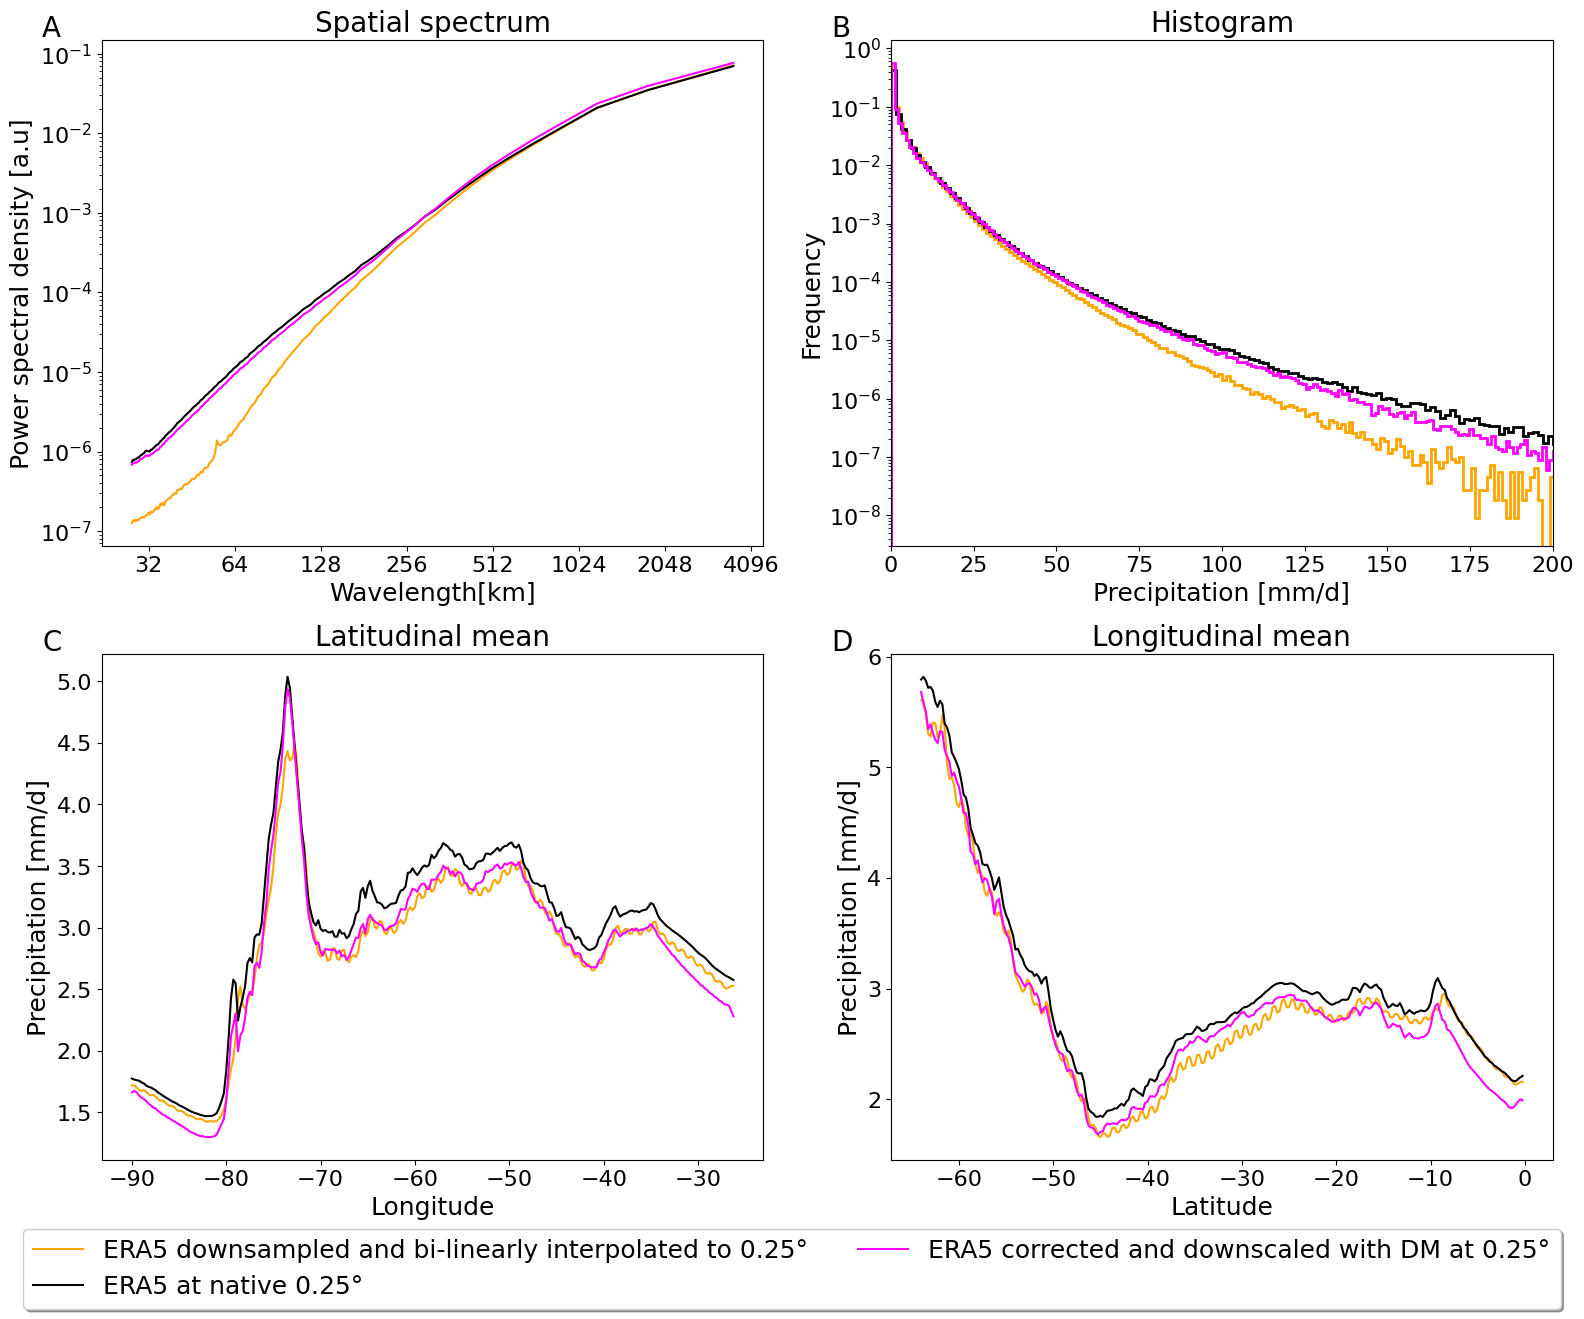

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

axs[0, 0]
ssd = SpatialSpectralDensity_diff_res(era5_lr_ds.inverse_dwd_trafo(era5_lr).numpy()
                                     ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                                     ,era5_hr_ds.inverse_dwd_trafo(dm_hr_era5.cpu().numpy()) 
                                     ,new_labels = ["ERA5 downsampled and bi-linearly interpolated to 0.25°",
                                                    "ERA5 at native 0.25°",
                                                     "ERA5 corrected and downscaled with DM at 0.25°"]
                                     ,title="Spatial spectrum")
ssd.run(num_times=None)
ssd.plot_psd(model_resolution=0.25, model_resolution_2 = 0.25, axis=axs[0, 0],do_savefig=False)
axs[0, 0].text(-0.09, 1.05, 'A', transform=axs[0, 0].transAxes,fontsize=20, fontweight='light', va='top')
axs[0, 0].set_title("Spatial spectrum", fontsize=20)  
axs[0, 1]
histograms_paper(era5_lr_ds.inverse_dwd_trafo(era5_lr).numpy()
                 ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                 ,era5_hr_ds.inverse_dwd_trafo(dm_hr_era5.cpu().numpy()) 
                 ,xlim_end=200, bins=300, y_ax_name="Frequency", x_ax_name="Precipitation [mm/d]"
                 , label_name=["ERA5 downsampled and bi-linearly interpolated to 0.25°",
                             "ERA5 at native 0.25°",
                             "ERA5 corrected and downscaled with DM at 0.25°"], ax=axs[0, 1])
axs[0, 1].text(-0.09, 1.05, 'B', transform=axs[0, 1].transAxes,fontsize=20, fontweight='light', va='top')
axs[0, 1].set_title("Histogram", fontsize=20)  
axs[1, 0]
latitudinal_profile_three(era5_lr_ds.inverse_dwd_trafo(era5_lr).numpy()
                         ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                         ,era5_hr_ds.inverse_dwd_trafo(dm_hr_era5.cpu().numpy())
                           ,y_ax_name="Precipitation [mm/d]"
                           ,label_name=["ERA5 downsampled and bi-linearly interpolated to 0.25°",
                                        "ERA5 at native 0.25°",
                                         "ERA5 corrected and downscaled with DM at 0.25°"]
                         ,do_savefig=False,ax=axs[1, 0])
axs[1, 0].text(-0.09, 1.05, 'C', transform=axs[1, 0].transAxes,fontsize=20, fontweight='light', va='top')
axs[1, 0].set_title("Latitudinal mean", fontsize=20)
axs[1, 1]
longitudinal_profile_three(era5_lr_ds.inverse_dwd_trafo(era5_lr).numpy()
                         ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                         ,era5_hr_ds.inverse_dwd_trafo(dm_hr_era5.cpu().numpy())
                           ,y_ax_name="Precipitation [mm/d]"
                           ,label_name=["ERA5 downsampled and bi-linearly interpolated to 0.25°",
                                        "ERA5 at native 0.25°",
                                         "ERA5 corrected and downscaled with DM at 0.25°"],
                           do_savefig=False,ax=axs[1, 1]) 
axs[1, 1].text(-0.09, 1.05, 'D', transform=axs[1, 1].transAxes,fontsize=20, fontweight='light', va='top')
axs[1, 1].set_title("Longitudinal mean", fontsize=20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0)
           ,fancybox=True, shadow=True, ncol=2, fontsize=18)


plt.tight_layout(rect=[0, 0.06, 1, 0.95])
#plt.savefig('figures_paper/era5_eval.pdf', dpi=300)  
plt.show()

#  Evaluate sr-bc gfdl

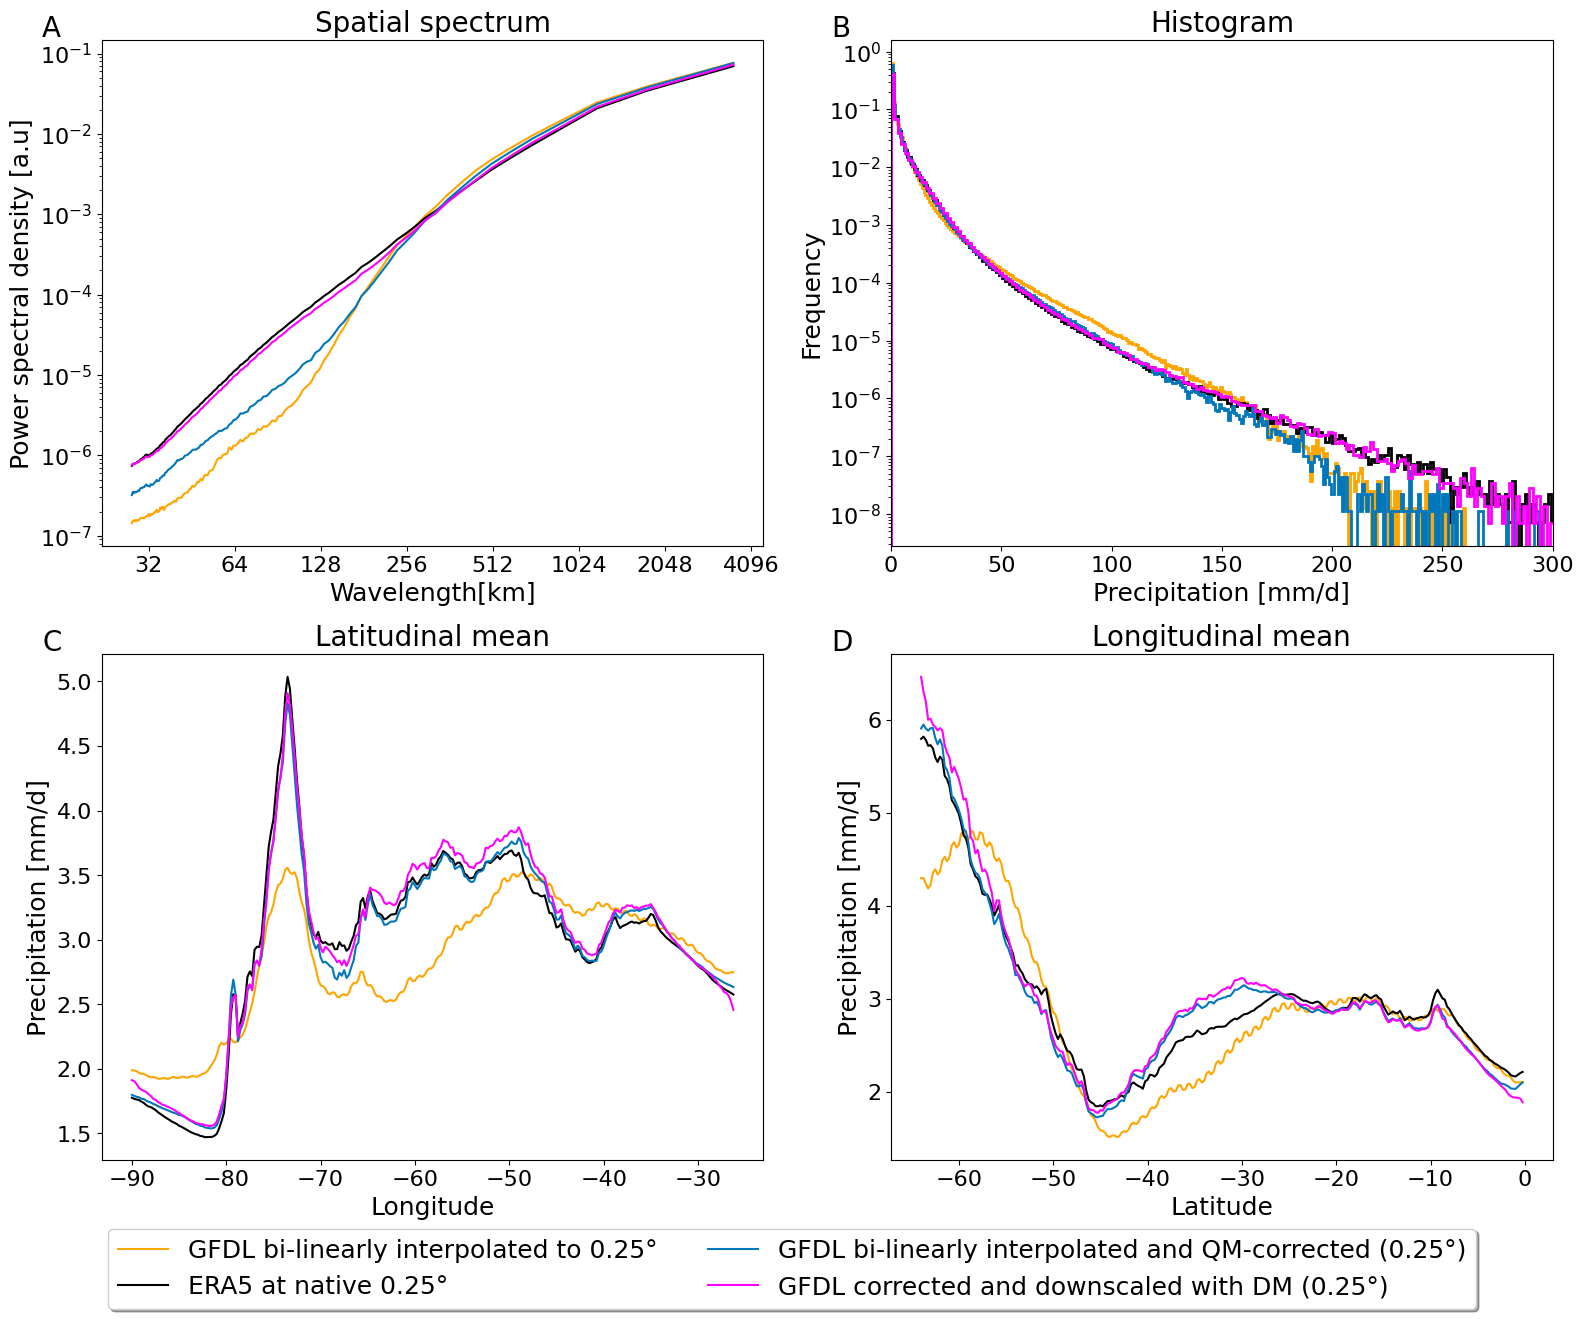

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))

axs[0, 0]
ssd = SpatialSpectralDensity_4_diff_res( gfdl_256_ds.inverse_dwd_trafo(gfdl_256).numpy()
                                      ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                                      ,qm_gfdl.numpy() 
                                      ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl).numpy()
                                      ,new_labels=['GFDL bi-linearly interpolated to 0.25°',
                                                   'ERA5 at native 0.25°',
                                                   "GFDL bi-linearly interpolated and QM-corrected (0.25°)",
                                                   'GFDL corrected and downscaled with DM (0.25°)']
                                      ,y_ax_name='Power spectral density [a.u]',x_ax_name=r'Wavelength[km]',
                                       title="Spatial spectrum" )
ssd.run(num_times=None)

ssd.plot_psd(model_resolution=0.25,model_resolution_2=0.25, do_savefig=False, axis=axs[0, 0])
axs[0, 0].text(-0.09, 1.05, 'A', transform=axs[0, 0].transAxes,fontsize=20, fontweight='light', va='top')
axs[0, 0].set_title("Spatial spectrum", fontsize=20)  
axs[0, 1]
histograms_four_np(  gfdl_256_ds.inverse_dwd_trafo(gfdl_256).numpy()
                      ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                      ,qm_gfdl.numpy() 
                      ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl).numpy() 
                      ,label_name=['GFDL bi-linearly interpolated to 0.25°',
                                   'ERA5 at native 0.25°',
                                   "GFDL bi-linearly interpolated and QM-corrected (0.25°)",
                                   'GFDL corrected and downscaled with DM (0.25°)'  ]
                     ,xlim_end=300,bins=300 ,y_ax_name="Frequency",x_ax_name="Precipitation [mm/d]"
                     ,title_name="Histogram"
                     ,do_savefig=False, ax=axs[0, 1])
axs[0, 1].text(-0.09, 1.05, 'B', transform=axs[0, 1].transAxes,fontsize=20, fontweight='light', va='top')
axs[0, 1].set_title("Histogram", fontsize=20)  # Increase title size
axs[1, 0]
latitudinal_mean_four_np( gfdl_256_ds.inverse_dwd_trafo(gfdl_256).numpy()
                          ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                          ,qm_gfdl.numpy() 
                          ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl).numpy() 
                          ,label_name=['GFDL bi-linearly interpolated to 0.25°',
                                          'ERA5 at native 0.25°',
                                          "GFDL bi-linearly interpolated and QM-corrected (0.25°)",
                                          'GFDL corrected and downscaled with DM (0.25°)']
                          ,y_ax_name="Precipitation [mm/d]",x_ax_name="Longitude"
                         ,title_name="Latitudinal mean"
                         ,do_savefig=False, ax=axs[1, 0]) 
axs[1, 0].text(-0.09, 1.05, 'C', transform=axs[1, 0].transAxes,fontsize=20, fontweight='light', va='top')
axs[1, 0].set_title("Latitudinal mean", fontsize=20)
axs[1, 1]
longitudinal_mean_four_np( gfdl_256_ds.inverse_dwd_trafo(gfdl_256).numpy()
                          ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                          ,qm_gfdl.numpy() 
                          ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl).numpy() 
                          ,label_name=['GFDL bi-linearly interpolated to 0.25°',
                                          'ERA5 at native 0.25°',
                                          "GFDL bi-linearly interpolated and QM-corrected (0.25°)",
                                          'GFDL corrected and downscaled with DM (0.25°)']
                          ,y_ax_name="Precipitation [mm/d]",x_ax_name="Latitude"
                         ,title_name="Longitudinal mean"
                         ,do_savefig=False, ax=axs[1, 1])
axs[1, 1].text(-0.09, 1.05, 'D', transform=axs[1, 1].transAxes,fontsize=20, fontweight='light', va='top')
axs[1, 1].set_title("Longitudinal mean", fontsize=20)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0)
           ,fancybox=True, shadow=True, ncol=2, fontsize=18)

plt.tight_layout(rect=[0, 0.06, 1, 0.95])
#plt.savefig('figures_paper/gfdl_eval_profiles.pdf', dpi=300)
plt.show()

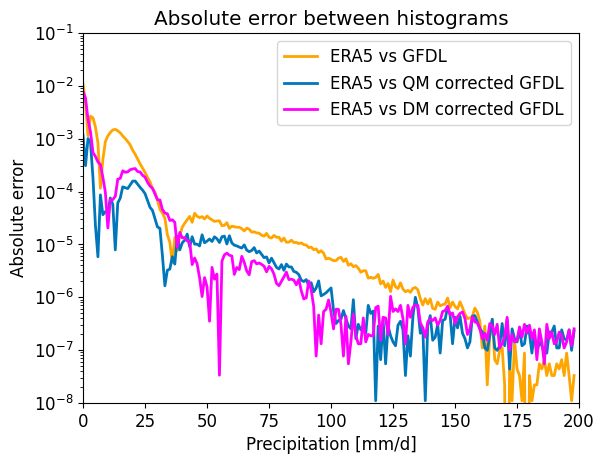

In [13]:
plot_absolute_errors_single(gfdl_256_ds.inverse_dwd_trafo(gfdl_256).numpy()
                              ,era5_hr_ds.inverse_dwd_trafo(era5_hr).numpy()
                              ,qm_gfdl.numpy() #era5_lr_ds.inverse_dwd_trafo(qm_gfdl).numpy()
                              ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl).numpy()
                             ,bin_end=200,y_ax_name='Absolute error',x_ax_name='Precipitation [mm/d]'
                             ,title_name='Absolute error between histograms',xlim=200
                            ,do_savefig=False)
                            #,do_savefig='figures_paper/absolute_error_single.pdf')  

# Plot absolute errors gfdl

In [14]:
#### bias in time + average bias in time (averaged over space) ####   x->256x256(t bias) -> 1 (avg t bias)

avg_sr_gfdl = torch.mean(era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl[:,:,:,:]).squeeze(1), axis=0)
avg_era5 = torch.mean(era5_hr_ds.inverse_dwd_trafo(era5_hr[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl = torch.mean(gfdl_256_ds.inverse_dwd_trafo(gfdl_256[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl_qm = torch.mean(qm_gfdl[:,:,:,:].squeeze(1), axis=0)
#avg_gfdl_qm = torch.mean(era5_lr_ds.inverse_dwd_trafo(qm_gfdl[:,:,:,:]).squeeze(1), axis=0)


mean_bias_dm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_sr_gfdl)).item(), 2)
print("Mean bias DM-corrected GFDL",mean_bias_dm_gfdl)
mean_bias_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_gfdl)).item(), 2)
print("Mean bias GFDL",mean_bias_gfdl)
mean_bias_qm_gfdl = round(torch.mean(torch.abs(avg_era5 - avg_gfdl_qm)).item(), 2)
print("Mean bias QM-corrected GFDL",mean_bias_qm_gfdl)

Mean bias DM-corrected GFDL 0.29
Mean bias GFDL 0.69
Mean bias QM-corrected GFDL 0.26


Saving to figures_paper/climatologies_main.pdf


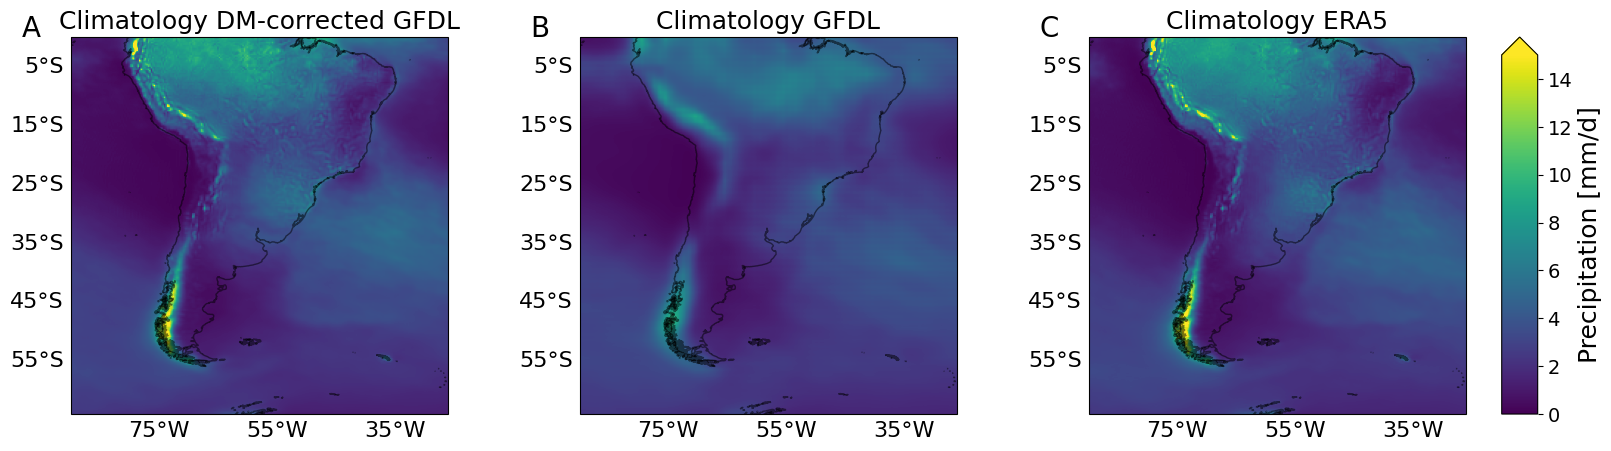

In [30]:
def plot_precipitation(ax, data, title, max_value=3):
    cmap = 'viridis'
    norm = plt.Normalize(vmin=0, vmax=max_value)
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.35, hspace=0.25)

max_value = 15

img1 = plot_precipitation(axes[0], avg_sr_gfdl, "", max_value)
axes[0].text(-0.13, 1.06, 'A', transform=axes[0].transAxes, fontsize=20, fontweight='light', va='top')
axes[0].set_title(f'Climatology DM-corrected GFDL', fontsize=18)

img2 = plot_precipitation(axes[1], avg_gfdl, "", max_value)
axes[1].text(-0.13, 1.06, 'B', transform=axes[1].transAxes, fontsize=20, fontweight='light', va='top')
axes[1].set_title(f'Climatology GFDL', fontsize=18)

img3 = plot_precipitation(axes[2], avg_era5, "", max_value)
axes[2].text(-0.13, 1.06, 'C', transform=axes[2].transAxes, fontsize=20, fontweight='light', va='top')
axes[2].set_title(f'Climatology ERA5', fontsize=18)

for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height])  # Center the colorbar vertically and set its size
cbar = fig.colorbar(img1, cax=cbar_ax, extend="max", orientation="vertical")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Precipitation [mm/d]' , fontsize=18)

save_figu = False
if save_figu == True:
    plt.savefig("figures_paper/climatologies_main.pdf", dpi=1000,bbox_inches='tight')
    print("Saving to figures_paper/climatologies_main.pdf")
plt.show()

Saving to figures_paper/abs_mean_bias.pdf


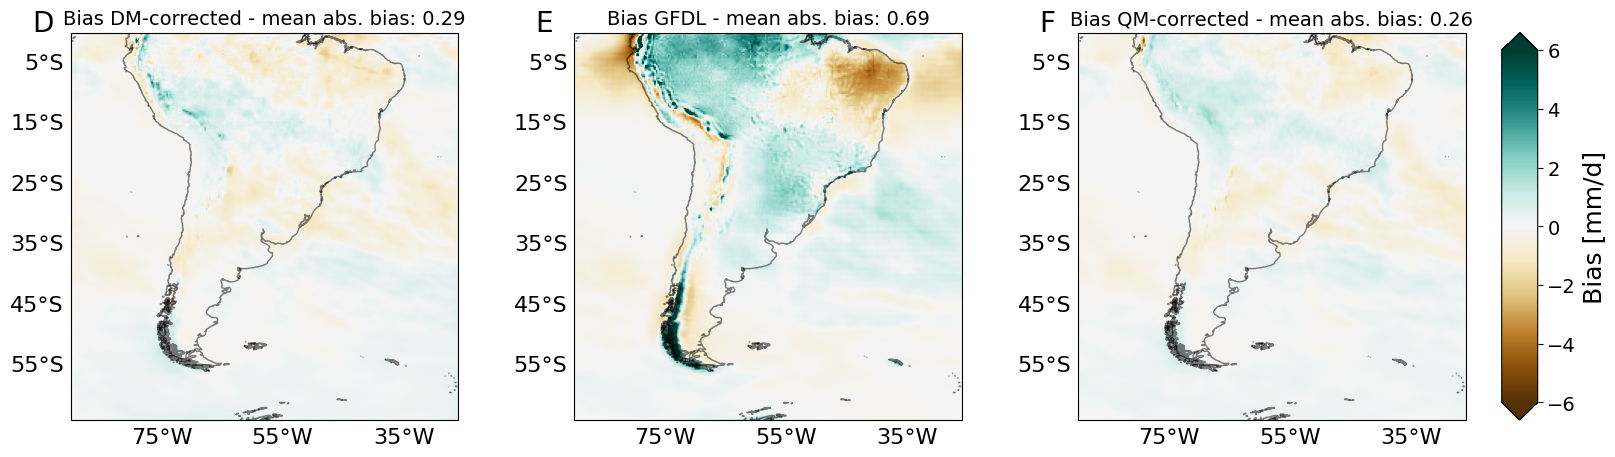

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import torch

def plot_precipitation(ax, data, title, max_value=3):
    cmap = "BrBG"  #"RdBu_r"
    norm = plt.Normalize(vmin=-max_value, vmax=max_value)
    img = ax.imshow(data, cmap=cmap, norm=norm, extent=[-90, -26, -64, 0])
    ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_title(title)
    return img

latitudes = np.arange(-90, -26, 0.25)
longitudes = np.arange(0, -64, -0.25)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0.3, hspace=0.3)

max_value = 6

img1 = plot_precipitation(axes[0], avg_era5 - avg_sr_gfdl, f'Absolute error of DM-corrected with respect to ERA5: {mean_bias_dm_gfdl}', max_value)
axes[0].text(-0.1, 1.06, 'D', transform=axes[0].transAxes, fontsize=20, fontweight='light', va='top')  # Add label 'A'
axes[0].set_title(f'Bias DM-corrected - mean abs. bias: {mean_bias_dm_gfdl}', fontsize=14)

img2 = plot_precipitation(axes[1], avg_era5 - avg_gfdl, f'Absolute error of GFDL with respect to ERA5: {mean_bias_gfdl}', max_value)
axes[1].text(-0.1, 1.06, 'E', transform=axes[1].transAxes, fontsize=20, fontweight='light', va='top')  # Add label 'B'
axes[1].set_title(f'Bias GFDL - mean abs. bias: {mean_bias_gfdl}', fontsize=14)

img3 = plot_precipitation(axes[2], avg_era5 - avg_gfdl_qm, f'BAbsolute error of QM-corrected to ERA5: {mean_bias_qm_gfdl}', max_value)
axes[2].text(-0.1, 1.06, 'F', transform=axes[2].transAxes, fontsize=20, fontweight='light', va='top')  # Add label 'C'
axes[2].set_title(f'Bias QM-corrected - mean abs. bias: {mean_bias_qm_gfdl}', fontsize=14)

# Set custom tick positions and labels for the x-axis and y-axis in each subplot
for ax in axes:
    ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = ticker.FixedLocator([-35, -45, -55, -65, -75, -85])  
    gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, -45, -55, -65])
    gl.xlabel_style = {'size': 16}  
    gl.ylabel_style = {'size': 16}

# Calculate the height of the colorbar based on the height of the axes
bbox = axes[0].get_position()
colorbar_height = bbox.height

cbar_ax = fig.add_axes([0.92, bbox.y0, 0.02, colorbar_height])  # Center the colorbar vertically and set its size
cbar = fig.colorbar(img1, cax=cbar_ax, extend="both", orientation="vertical")
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Bias [mm/d]' , fontsize=18)


save_figu = False
if save_figu == True:
    plt.savefig("figures_paper/abs_mean_bias.pdf", dpi=1000,bbox_inches='tight')
    print("Saving to figures_paper/abs_mean_bias.pdf")
    plt.show()

In [26]:
def plot_images_with_captions(images_list, max_value=50, do_savefig=False):
    num_images = len(images_list)
    num_vars = len(images_list[0])
    # Calculate the minimum and maximum values for normalization across all images
    all_images = [image.squeeze().cpu().detach().numpy() for sublist in images_list for image in sublist]
    
    min_value = 0
    max_value = max_value
    
    fig, axs = plt.subplots(num_images, num_vars, figsize=(num_vars * 4 + 1, num_images * 4), 
                            subplot_kw={'projection': ccrs.PlateCarree()})
    plt.subplots_adjust(left=0.02, right=0.9, top=0.98, bottom=0.1, wspace=0.2, hspace=0.2)
    
    for i in range(num_images):
        for j in range(num_vars):
            ax = axs[i, j]
            img_data = images_list[i][j].squeeze().cpu().detach().numpy()  
            
            ax.imshow(img_data, extent=[-90, -26, -64, 0], origin='upper', transform=ccrs.PlateCarree(),
                      vmin=min_value, vmax=max_value,  cmap='viridis')
            ax.coastlines(resolution='10m', color='black', linewidth=1, alpha=0.5)
            ax.add_feature(cfeature.LAND, color='lightgray')

            if i == 0:
                title_prefix = "GFDL - sample"
            elif i == 1:
                title_prefix = "QM-corrected GFDL - sample"
            elif i == 2:
                title_prefix = "DM-corrected GFDL - sample"
            elif i == 3:
                title_prefix = "ERA5 - sample"

            ax.set_title('{} {}'.format(title_prefix, j + 1))  
            ax.set_extent([-90, -26, -64, 0], crs=ccrs.PlateCarree())  
            #ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0)
            gl.top_labels = False
            gl.right_labels = False
            
            gl.xlocator = ticker.FixedLocator([-35,- 45, -55, -65 , -75 , -85])  
            gl.ylocator = ticker.FixedLocator([-5, -15, -25, -35, - 45, -55, -65])
            
            gl.xlabel_style = {'size': 10}  
            gl.ylabel_style = {'size': 10}

    # Adjust the position and size of the colorbar axes
    cbar_ax = fig.add_axes([0.35, 0.05, 0.25, 0.02])  
    cbar = fig.colorbar(axs[0, 0].images[0], cax=cbar_ax, orientation='horizontal', extend="max")
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('Precipitation [mm/d]',fontsize=18)

    if do_savefig:
        plt.savefig(do_savefig, dpi=1000,bbox_inches='tight')
        print("Saving to", do_savefig)
    plt.show()

Saving to figures_paper/individual_samples.pdf


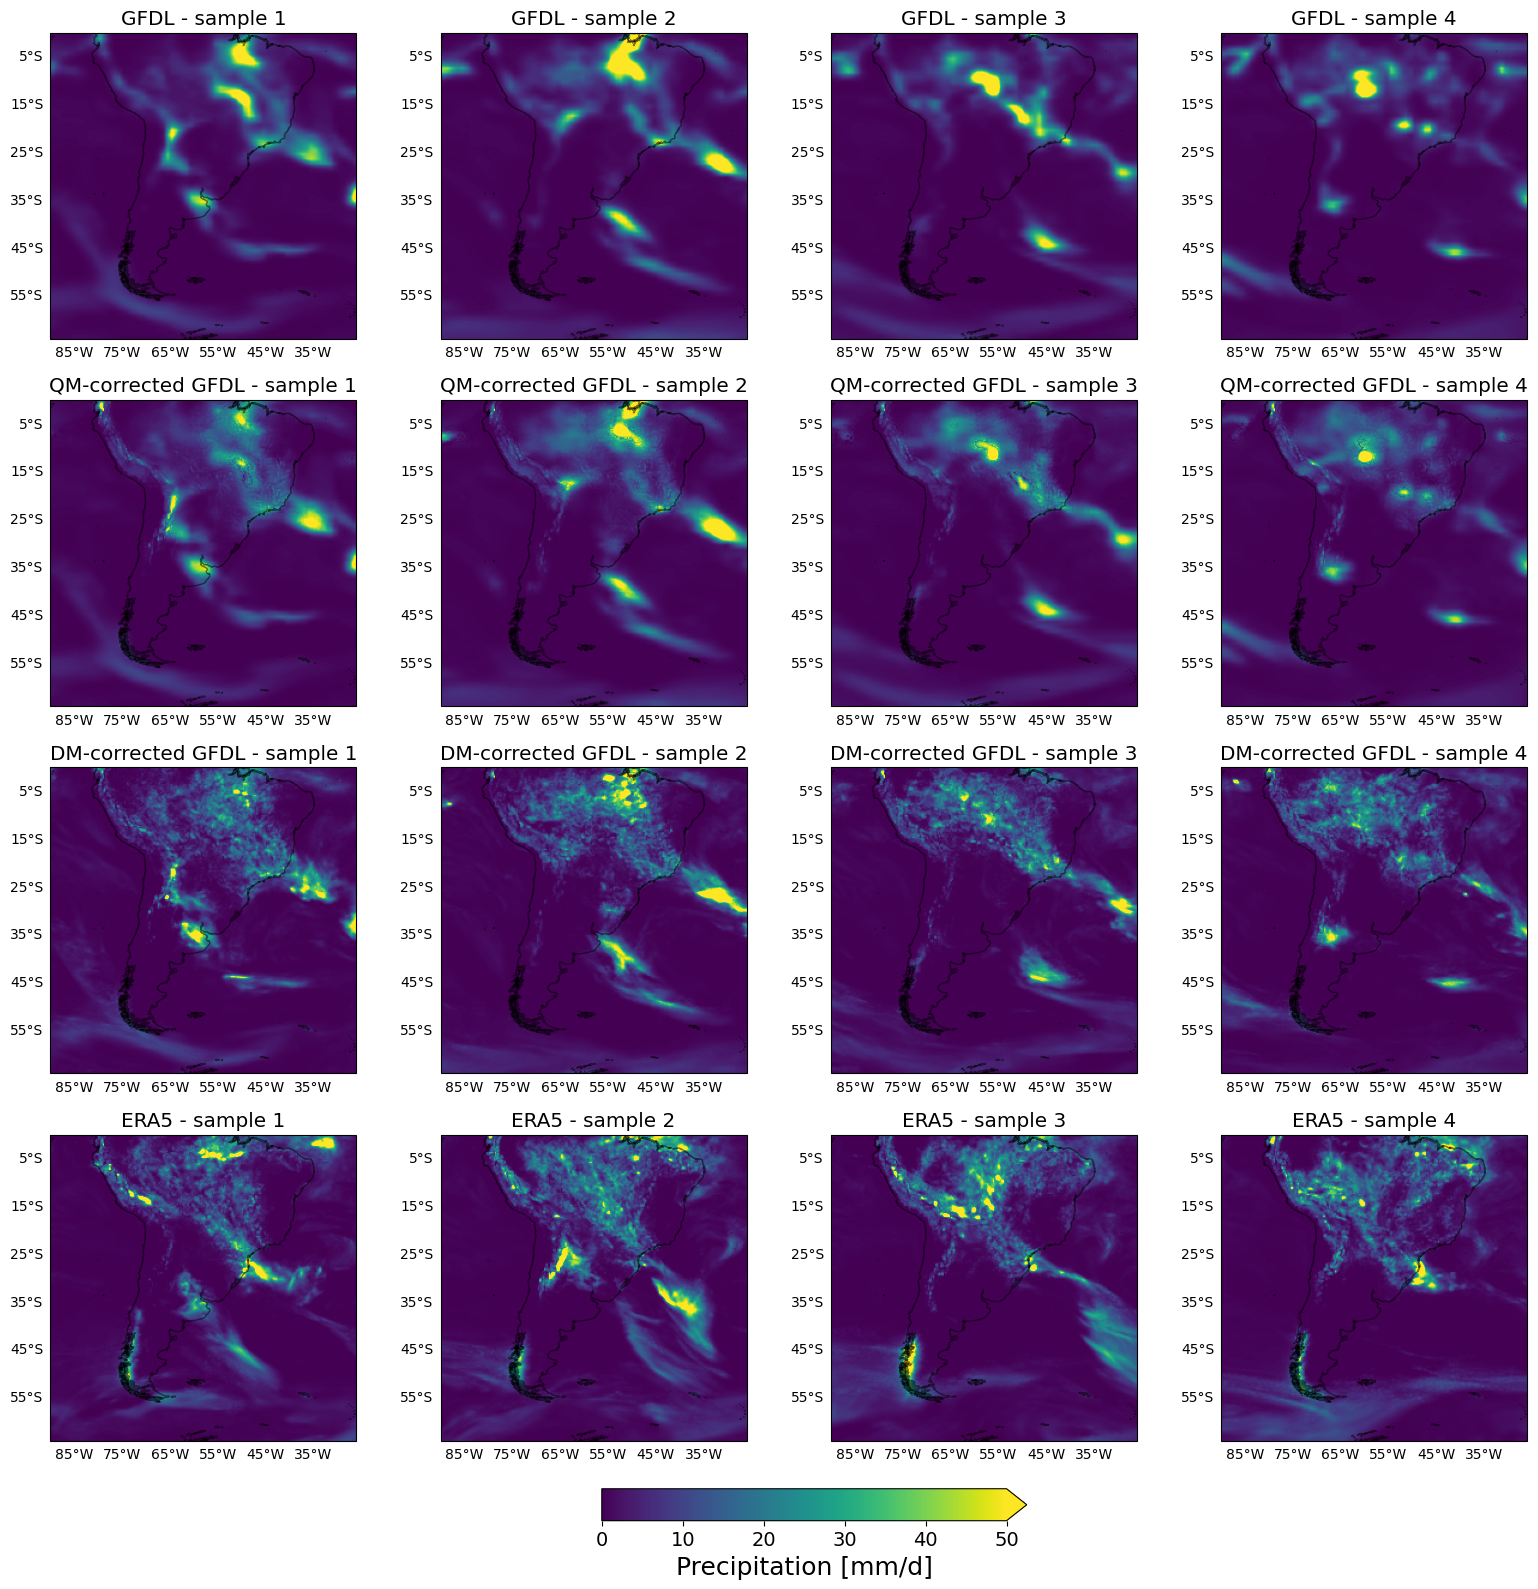

In [27]:
a = 17

plot_images_with_captions([(gfdl_256_ds.inverse_dwd_trafo(gfdl_256))[a:a+4] 
                           ,qm_gfdl[a:a+4] 
                           ,era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl)[a:a+4] 
                           ,era5_hr_ds.inverse_dwd_trafo(era5_hr)[a:a+4] ]
                           ,max_value=50
                           ,do_savefig=False)
                           #,do_savefig="figures_paper/individual_samples.pdf")

# SSIM and Pearson Correlation


In [12]:
blur_gfdl = transforms.GaussianBlur(kernel_size=51, sigma=(2,2))(gfdl_256)   #was 3 and 0.8
blur_dm = transforms.GaussianBlur(kernel_size=51, sigma=(2,2))(dm_sr_gfdl)

In [13]:
print(blur_gfdl.shape, blur_dm.shape)

torch.Size([1400, 1, 256, 256]) torch.Size([1400, 1, 256, 256])


In [14]:
ssim_dm_gfdl = ssim(blur_dm.squeeze(1).numpy(), blur_gfdl.squeeze(1).numpy()
                    ,data_range=blur_dm.squeeze(1).numpy().max() - blur_dm.squeeze(1).numpy().min())

print("avg ssim Gaussian filter BC GFDL vs GFDL:", np.mean(ssim_dm_gfdl))

avg ssim Gaussian filter BC GFDL vs GFDL: 0.8358950948334474


In [15]:
# Calculate Pearson correlation coefficient
pearson_corr_coefficient, _ = pearsonr(blur_dm.squeeze(1).numpy().flatten(), blur_gfdl.squeeze(1).numpy().flatten())
print("Pearson correlation coefficient:", pearson_corr_coefficient)

Pearson correlation coefficient: 0.9252772115070085


# pearson correlation no QM

In [16]:
dm_sr_no_qm_ds = SR_BC_GFDL_Dataset_256('data/revision_no_qm_gfdl_sr_imagen_100step_e100_17_09.pth') 
dm_sr_no_qm_dl = data.DataLoader(dm_sr_no_qm_ds, batch_size=bs_valid,shuffle=False, drop_last=True)

dm_sr_no_qm = next(iter(dm_sr_no_qm_dl)).cpu()
dm_sr_no_qm = era5_hr_ds.inverse_dwd_trafo(dm_sr_no_qm)

print("SR GFDL no QM",dm_sr_no_qm.shape)

dataset size torch.Size([1420, 1, 256, 256])
SR GFDL no QM torch.Size([1400, 1, 256, 256])


In [17]:
def compute_spatial_correlation(image1, image2):
    """
    Compute the spatial correlation between two images.
    
    Parameters:
    image1 (numpy array): First image
    image2 (numpy array): Second image
    
    Returns:
    correlation (float): Spatial correlation coefficient
    """
    # Flatten the images to 1D arrays
    flat1 = image1.flatten()
    flat2 = image2.flatten()
    
    # Compute the Pearson correlation coefficient
    correlation = np.corrcoef(flat1, flat2)[0, 1]
    return correlation

def calculate_climatology(data):
    return torch.mean(data, axis=0)

In [18]:
avg_sr_gfdl = torch.mean(era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl[:,:,:,:]).squeeze(1), axis=0)
avg_era5 = torch.mean(era5_hr_ds.inverse_dwd_trafo(era5_hr[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl = torch.mean(gfdl_256_ds.inverse_dwd_trafo(gfdl_256[:,:,:,:]).squeeze(1), axis=0)
avg_gfdl_qm = torch.mean(qm_gfdl[:,:,:,:].squeeze(1), axis=0)

In [19]:
era5_climatology = calculate_climatology(era5_hr_ds.inverse_dwd_trafo(era5_hr[:,:,:,:]))
gfdl_climatology = calculate_climatology(gfdl_256_ds.inverse_dwd_trafo(gfdl_256[:,:,:,:]))
dm_climatology = calculate_climatology(era5_hr_ds.inverse_dwd_trafo(dm_sr_gfdl[:,:,:,:]))
qm_climatology = calculate_climatology(qm_gfdl)


dm_no_qm_climatology = calculate_climatology(dm_sr_no_qm)

In [20]:
correlation_no_qm = compute_spatial_correlation(dm_no_qm_climatology, era5_climatology)
correlation_gfdl = compute_spatial_correlation(gfdl_climatology, era5_climatology)
correlation_dm = compute_spatial_correlation(dm_climatology, era5_climatology)
correlation_qm = compute_spatial_correlation(qm_climatology, era5_climatology)

In [21]:
print("correlation_no_qm", correlation_no_qm)
print("correlation_gfdl", correlation_gfdl)
print("correlation_dm", correlation_dm)
print("correlation_qm", correlation_qm)

correlation_no_qm 0.8894052176297234
correlation_gfdl 0.8316379950158126
correlation_dm 0.9796331106884014
correlation_qm 0.9842819016461839
